In [1]:
from pathlib import Path
from omegaconf import OmegaConf
import torch
import numpy as np
from matplotlib import pyplot as plt
import cv2

from gluefactory.datasets import get_dataset
from gluefactory.utils.tensor import batch_to_device
from gluefactory.geometry.gt_generation import gt_matches_from_pose_depth, gt_matches_from_homography
from gluefactory.models import get_model


In [ ]:
def draw_keypoints_cv(image, kps, color = (0, 255, 0), select_kp = None):
  if image.shape[0] == 3:  # RGB
    scale = image.new_tensor([0.299, 0.587, 0.114]).view(3, 1, 1)
    image = (image * scale).sum(0)
    print(image.shape)
  image = image.detach().cpu().numpy()
  image = (image * 255).astype(np.uint8)
  kps = kps.detach().cpu().numpy()
    
  cv_kps= [cv2.KeyPoint(kp[0], kp[1], 1) for kp in kps]
  out_img = cv2.drawKeypoints(image, cv_kps, None, color=color, flags=0)

  if select_kp is not None:
    for kp in select_kp:
      cv2.circle(out_img, (int(kps[kp][0]), int(kps[kp][1])), 5, (255, 0, 0), -1)

  return out_img

: 

In [ ]:
def draw_stats(data):
    # arg: data Nx2
    print(f'Max and Min and Median x: {data[:, 0].max()}, {data[:, 0].min()}, {data[:, 0].median()}')
    print(f'Max and Min and Median y: {data[:, 1].max()}, {data[:, 1].min()}, {data[:, 1].median()}')
    data= data.numpy()
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # draw x, y value as bar chart
    ax1.bar(np.arange(len(data)), data[:, 0])
    ax1.set_title('X values')
    ax2.bar(np.arange(len(data)), data[:, 1])
    ax2.set_title('Y values')

: 

In [ ]:
# conf = OmegaConf.load(file_="../gluefactory/configs/superpoint+simpleglue_homography_debug.yaml")
conf = OmegaConf.load(file_="../gluefactory/configs/superpoint+simpleglue_megadepth_debug.yaml")

: 

In [ ]:
data_conf = (conf.data)
dataset = get_dataset(data_conf.name)(data_conf)

[08/17/2025 23:11:24 gluefactory.datasets.base_dataset INFO] Creating dataset MegaDepth


: 

In [ ]:
train_loader = dataset.get_data_loader("train", distributed=False)
itr = iter(train_loader)


[08/17/2025 23:11:24 gluefactory.datasets.megadepth INFO] Sampling new train data with seed 0.


: 

In [ ]:
extractor = get_model(conf.model.extractor.name)(conf.model.extractor)

: 

In [ ]:
gt_matcher = get_model(conf.model.ground_truth.name)(conf.model.ground_truth)

: 

In [ ]:
data = next(itr)   # first batch

pred0 = extractor(data["view0"])
pred1 = extractor(data["view1"])
pred = {
    **{k + "0": v for k, v in pred0.items()},
    **{k + "1": v for k, v in pred1.items()},
}

gt_pred = gt_matcher({**data, **pred})

: 

In [ ]:
res0_1_sq = gt_pred["res0_1_sq"][0]
res1_0_sq = gt_pred["res1_0_sq"][0]

dist0_min = torch.sum(res0_1_sq, -1).min(-1).values
best_idx0 = torch.argmin(dist0_min)
worst_idx0 = torch.argmax(dist0_min)
dist1_min = torch.sum(res1_0_sq, -1).min(-1).values
best_idx1 = torch.argmin(dist1_min)
worst_idx1 = torch.argmax(dist1_min)



: 

Max and Min and Median x: 102.39665222167969, 3.74793671653606e-06, 20.549776077270508
Max and Min and Median y: 112.49134826660156, 5.257562634142232e-07, 21.073322296142578
Max and Min and Median x: 343.5945739746094, 1.3178705557947978e-06, 72.20311737060547
Max and Min and Median y: 52.21508026123047, 3.1592469440511195e-07, 10.26361083984375


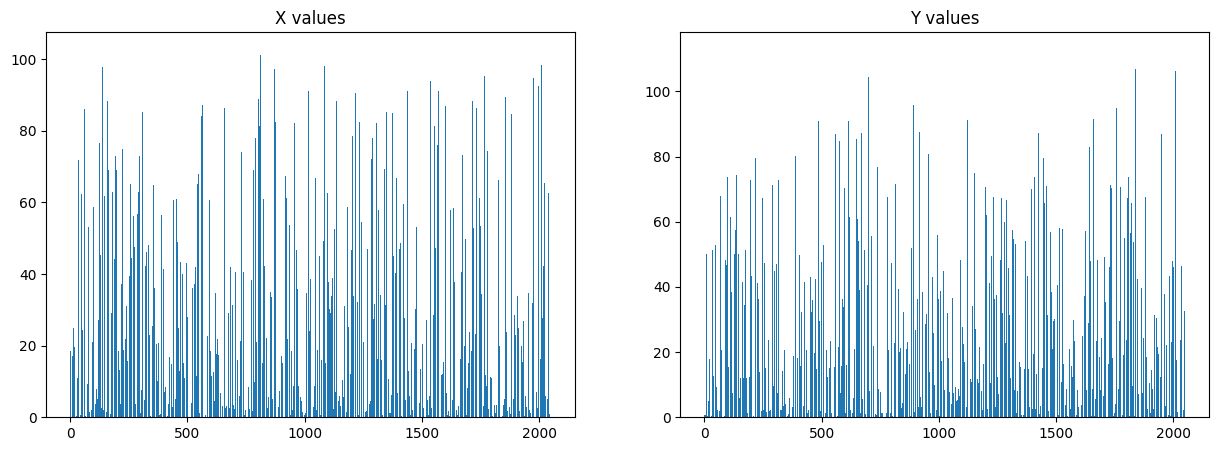

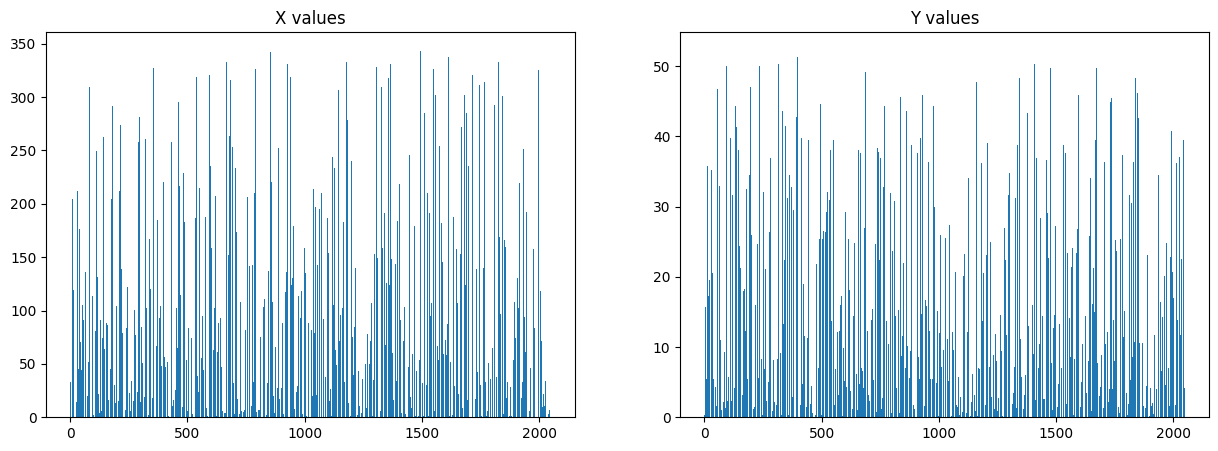

: 

In [ ]:
draw_stats(res0_1_sq[best_idx0, ...])
draw_stats(res1_0_sq[best_idx1, ...])

Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0
Max and Min and Median x: 40000.0, 40000.0, 40000.0
Max and Min and Median y: 40000.0, 40000.0, 40000.0


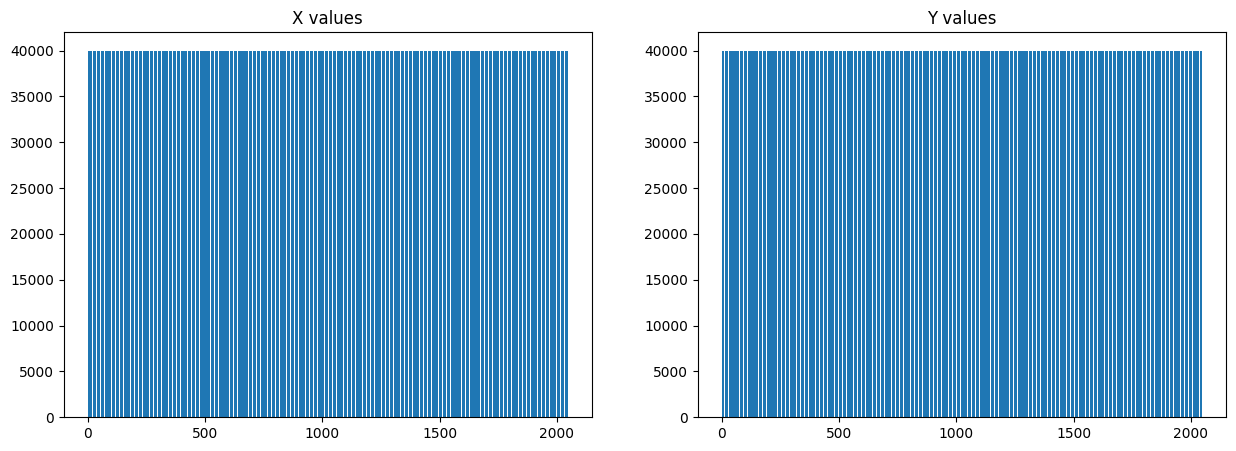

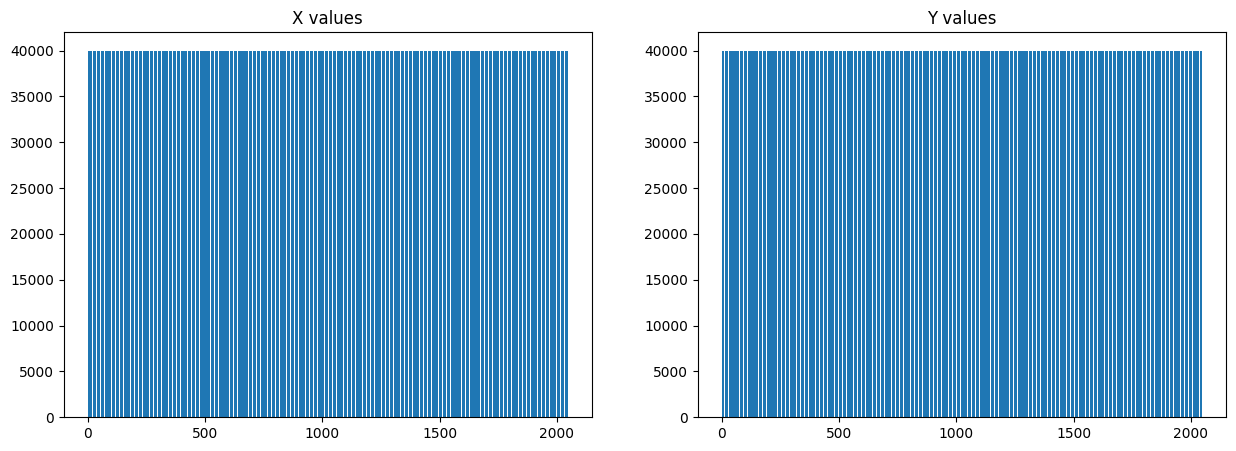

: 

In [ ]:
draw_stats(res0_1_sq[worst_idx0, ...])
draw_stats(res1_0_sq[worst_idx1, ...])

In [ ]:
valid0 = gt_pred["valid0_1"][0]
occluded_kp0s = torch.where((dist0_min==80000) & valid0)[0]
img0 = draw_keypoints_cv(data['view0']['image'][0], pred['keypoints0'][0], color=(0,255,0), select_kp=occluded_kp0s)
plt.imshow(img0)
plt.show()

NameError: name 'gt_pred' is not defined

: 

In [ ]:
data['view0']['image'][0].shape

torch.Size([3, 1024, 1024])

: 

torch.Size([1024, 1024])


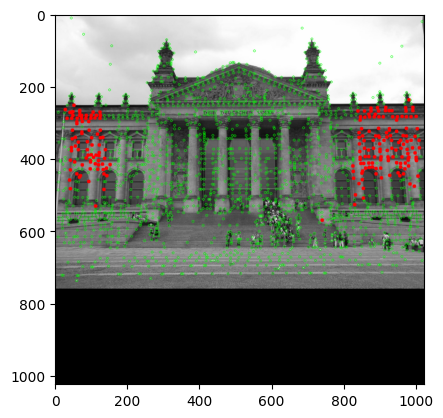

: 

In [ ]:
valid1 = gt_pred["valid1_0"][0]
occluded_kp1s = torch.where((dist1_min==80000) & valid1)[0]
img1 = draw_keypoints_cv(data['view1']['image'][0], pred["keypoints1"][0], color=(0,255,0), select_kp=occluded_kp1s)
plt.imshow(img1)
plt.show()


In [1]:
from gluefactory.models.matchers.simpleglue import PositionEmbeddingSine
import torch

In [2]:
mask = torch.ones((1, 480, 600), dtype=torch.bool)  # Example mask, adjust size as needed
pos_embed = PositionEmbeddingSine(num_pos_feats=128, normalize=True)
kpts = torch.ones((2, 100, 2))
size = torch.tensor([480, 600], dtype=torch.float32).unsqueeze(0)
pe = pos_embed(kpts, size)
print(pe.shape)

kpts shape and size shape torch.Size([2, 100, 2]) torch.Size([1, 2])
torch.Size([2, 100, 256])


In [3]:
torch.Size([1, 480, 600]) torch.Size([1, 480, 600]) torch.Size([64])
torch.Size([1, 128, 480, 600])

SyntaxError: invalid syntax (3295899793.py, line 1)